In [1]:
import pandas as pd
#from sep_util import read_file
import utm
import numpy as np
import h5py
import time
import tqdm
import obspy
import datetime
import os

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
# %matplotlib inline
params = {
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 18, # fontsize for x and y labels (was 10)
    'axes.titlesize': 18,
    'font.size': 18,
    'legend.fontsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'text.usetex':False,
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white'
}
matplotlib.rcParams.update(params)

In [2]:
def read_PASSCAL_segy(infile, nTraces, nSample, TraceOff=0):
    """Function to read PASSCAL segy raw data"""
    data = np.zeros((nTraces, nSample), dtype=np.float32)
    gzFile = False
    if infile.split(".")[-1] == "segy":
        fid = open(infile, 'rb')
    elif infile.split(".")[-1] == "gz":
        gzFile = True
        fid = gzip.open(infile, 'rb')
    fid.seek(3600)
    # Skipping traces if necessary
    fid.seek(TraceOff*(240+nSample*4),1)
    # Looping over traces
    for ii in range(nTraces):
        fid.seek(240, 1)
        if gzFile:
            # np.fromfile does not work on gzip file
            BinDataBuffer = fid.read(nSample*4) # read binary bytes from file
            data[ii, :] = struct.unpack_from(">"+('f')*nSample, BinDataBuffer)
        else:
            data[ii, :] = np.fromfile(fid, dtype=np.float32, count=nSample)
    fid.close()
    return data

In [3]:
# Define the path to store all the output results
output_dir = '/kuafu/yinjx/Ridgecrest/Ridgecrest_scaling'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [4]:
import glob
files = glob.glob('/kuafu/zshen/Ridgecrest_data/1hoursegy/total/*.segy')
files.sort()
print(f'Total file number: {len(files)}')
print(files[0])
print(files[-1])

Total file number: 15647
/kuafu/zshen/Ridgecrest_data/1hoursegy/total/2019071019.segy
/kuafu/zshen/Ridgecrest_data/1hoursegy/total/2021060600.segy


In [5]:
# load the DAS channel location
DAS_info = np.genfromtxt('/kuafu/DASdata/DASinfo/DAS_ChannelLocation/DAS_Ridgecrest_ODH3.txt')

DAS_channel_num = DAS_info.shape[0]
DAS_index = DAS_info[:, 0].astype('int')
DAS_lon = DAS_info[:, 1]
DAS_lat = DAS_info[:, 2]

### First read the catalog, the catalog is from STP with command:

```bash
EVENT -mag 2.0 8.0 -lat 33.65 37.65 -lon -119.72 -115.72 -t0 2019/7/10,18:00:00 2021/6/5,18:00:00 -f Ridgecrest_das_catalog_M2_M8.txt
```

In [6]:
catalog_file = '/home/yinjx/notebooks/strain_scaling/Ridgecrest_das_catalog_M2_M8.txt'
catalog = pd.read_csv(catalog_file, sep='\s+', header=None, skipfooter=1, engine='python')
catalog

,0,1,2,3,4,5,6,7,8,9
0,38521207,eq,l,"2019/07/10,18:00:01.250",35.7753,-117.6033,7.59,2.26,l,1.0
1,38521231,eq,l,"2019/07/10,18:01:27.840",35.6733,-117.5210,5.71,2.37,l,1.0
2,38521351,eq,l,"2019/07/10,18:11:09.650",35.7067,-117.5282,9.24,2.02,l,1.0
3,38521591,eq,l,"2019/07/10,18:30:10.250",35.6533,-117.5022,7.97,2.42,l,1.0
4,38521775,eq,l,"2019/07/10,18:44:42.310",35.6738,-117.5278,8.65,2.17,l,1.0
...,...,...,...,...,...,...,...,...,...,...
4409,39914032,eq,l,"2021/06/02,07:44:21.310",35.9512,-117.3327,3.37,2.16,l,1.0
4410,39915440,eq,l,"2021/06/03,04:48:33.690",34.3058,-116.9277,8.38,2.27,l,1.0
4411,39915912,eq,l,"2021/06/03,15:52:48.420",33.9922,-117.0828,16.10,2.13,l,1.0
4412,39916960,eq,l,"2021/06/04,12:18:09.310",33.9017,-116.1048,9.01,2.49,l,1.0


In [7]:
catalog_select = catalog[(catalog[7] >= 3) & (catalog[6] > 1)] # choose the event with magnitude > 3.5
#catalog_select = catalog[(catalog[7] >= 3) & (catalog[7] <= 3.5) & (catalog[6] > 1)] # choose the event with magnitude <= 3.5

In [8]:
eq_num = catalog_select.shape[0]
eq_id = np.array(catalog_select[0])
eq_time = np.array(catalog_select[3])
eq_lat = np.array(catalog_select[4])
eq_lon = np.array(catalog_select[5])
eq_dep = np.array(catalog_select[6])
eq_mag = np.array(catalog_select[7])

print(f'Total number of events: {eq_num}')

Total number of events: 452


In [9]:
# Convert the event time to obspy UTCDateTime and also find the corresponding DAS file name
import datetime
import obspy

# event time in obspy.UTCDateTime
eq_time_UTCDateTime = [obspy.UTCDateTime(temp) for temp in eq_time]
# corresponding das file name
eq_das_files = [datetime.datetime.strptime(temp[:-4],'%Y/%m/%d,%H:%M:%S').strftime('%Y%m%d%H.segy') for temp in eq_time]
# corresponding das data initial time in UTCDateTime form
eq_das_t0 = [obspy.UTCDateTime(temp[0:-5]) for temp in eq_das_files]

### Show a simple map for the DAS array and events

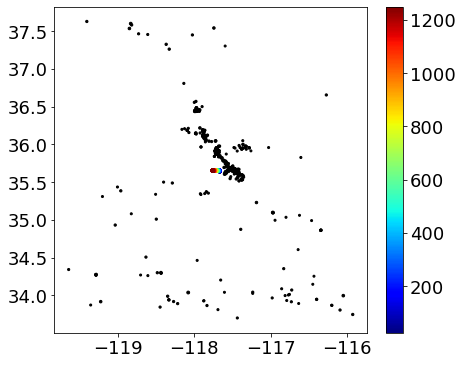

In [10]:
# TODO: add an inset with Zoom-in DAS channels
fig, ax = plt.subplots(figsize=(7, 6))
cmp = ax.scatter(DAS_lon, DAS_lat, s=10, c=DAS_index, cmap='jet')
ax.scatter(eq_lon, eq_lat, s=10**(eq_mag/5), c='k')
fig.colorbar(cmp)

### Calculate the arrival time from earthquake to each das channel using 1D velocity model. If the travel time table has already been calculated, load the prepared travel time table, calculate the interpolation function to estimate the arrival times.

In [17]:
# Work out a handy travel time table to do interpolation
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees

travel_time_table_file = output_dir + '/travel_time_table.npz'

# from one event to all channels
event_arrival_P = np.zeros((DAS_channel_num, eq_num)) 
event_arrival_S = np.zeros((DAS_channel_num, eq_num)) 

# First look for the precalculated TTT, if not exists, get one from interpolating TauP 
if not os.path.exists(travel_time_table_file):
    model = TauPyModel(model='iasp91')

    # distance list
    distance_fit = np.linspace(0, 2, 100)
    # depth list
    depth_fit = np.arange(0, 100, 1)

    distance_grid, depth_grid = np.meshgrid(distance_fit, depth_fit)


    tavel_time_P_grid = np.zeros(distance_grid.shape)
    tavel_time_S_grid = np.zeros(distance_grid.shape)

    #for i_eq in tqdm.tqdm(range(10), desc="Calculating arrival time..."):
    for i_depth in tqdm.tqdm(range(depth_grid.shape[0]), desc="Calculating arrival time..."):   

        for i_distance in range(distance_grid.shape[1]):
            try:
                arrivals = model.get_ray_paths(depth_fit[i_depth], distance_fit[i_distance], phase_list=['p', 's'])
                tavel_time_P_grid[i_depth, i_distance] = arrivals[0].time
                tavel_time_S_grid[i_depth, i_distance] = arrivals[1].time 
            except:
                tavel_time_P_grid[i_depth, i_distance] = np.nan
                tavel_time_S_grid[i_depth, i_distance] = np.nan

    # save the calculated Travel time table
    np.savez(travel_time_table_file, distance_grid=distance_grid, depth_grid=depth_grid, 
             tavel_time_p_grid=tavel_time_P_grid, tavel_time_s_grid=tavel_time_S_grid)

    print('Travel time table calculated!')
    
    
# The TTT calculated or already exists, directly load it.
temp = np.load(travel_time_table_file)
distance_grid = temp['distance_grid']
depth_grid = temp['depth_grid']
tavel_time_p_grid = temp['tavel_time_p_grid']
tavel_time_s_grid = temp['tavel_time_s_grid']

# build the interpolation function
from scipy.interpolate import interp2d, griddata
#grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')

ii = ~np.isnan(tavel_time_p_grid) # ignore the nan
# interp_f_p = interp2d(distance_grid[ii], depth_grid[ii], tavel_time_p_grid[ii], kind='linear')
# interp_f_s = interp2d(distance_grid[ii], depth_grid[ii], tavel_time_s_grid[ii], kind='linear')

for i_eq in tqdm.tqdm(range(eq_num), desc="Calculating arrival time..."):   
    # estimate the arrival time of each earthquake to all channels
    P_arrival = np.zeros(DAS_channel_num)
    S_arrival = np.zeros(DAS_channel_num)
    distance_to_source = locations2degrees(DAS_lat, DAS_lon, eq_lat[i_eq], eq_lon[i_eq])

    P_arrival = griddata(np.array([distance_grid[ii], depth_grid[ii]]).T, tavel_time_p_grid[ii], (distance_to_source, np.ones(distance_to_source.shape)*5))
    S_arrival = griddata(np.array([distance_grid[ii], depth_grid[ii]]).T, tavel_time_s_grid[ii], (distance_to_source, np.ones(distance_to_source.shape)*5))

    P_arrival = eq_time_UTCDateTime[i_eq] - eq_das_t0[i_eq] + P_arrival
    S_arrival = eq_time_UTCDateTime[i_eq] - eq_das_t0[i_eq] + S_arrival
    # P_arrival = eq_time_UTCDateTime[i_eq] - eq_das_t0[i_eq] + interp_f_p(distance_to_source, eq_dep[i_eq])
    # S_arrival = eq_time_UTCDateTime[i_eq] - eq_das_t0[i_eq] + interp_f_s(distance_to_source, eq_dep[i_eq])  


    event_arrival_P[:, i_eq] = P_arrival
    event_arrival_S[:, i_eq] = S_arrival

Calculating arrival time...: 100%|██████████| 452/452 [02:07<00:00,  3.56it/s]


### Output the windowed data for ML phase/arrival time picking

Extracting waveforms...:  31%|███       | 141/452 [44:54<1:39:02, 19.11s/it]


IndexError: cannot do a non-empty take from an empty axes.

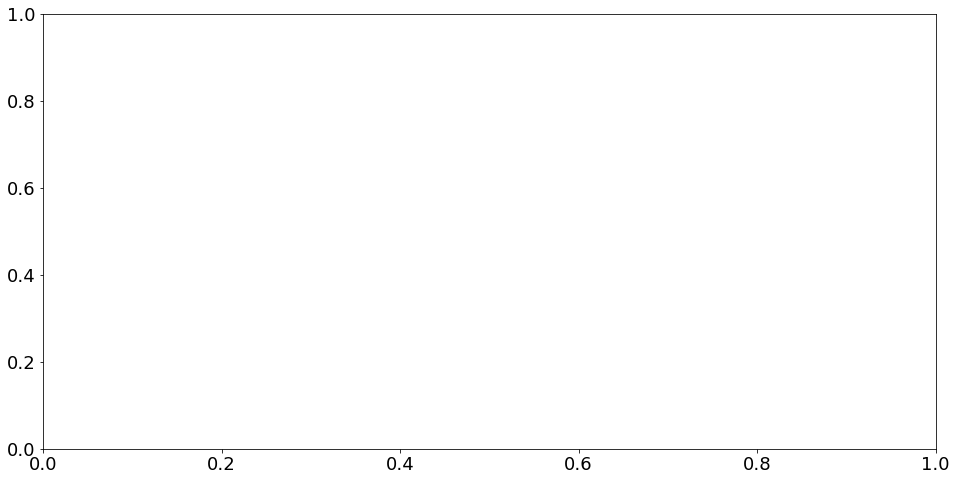

In [18]:
# Save the segmented data for ML phase picking
data_folder = '/kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/ML_picking_data_eye_picked'
for i_event in tqdm.tqdm(range(eq_num), desc="Extracting waveforms..."):
    try:
        das_path = '/kuafu/zshen/Ridgecrest_data/1hoursegy/total/'
        file_name = eq_das_files[i_event]

        data0 = read_PASSCAL_segy(das_path + file_name, 1250, 900000, 0)
        data0 = data0[DAS_index, :]
    except:
        continue

    das_dt = 3600 / data0.shape[1]
    data_diff = np.diff(data0, axis=1)/das_dt

    # time information 
    das_time = np.linspace(das_dt,3600-das_dt,data_diff.shape[1])

    # Taper the data
    t_begin = np.min(event_arrival_P[:, i_event]) - 10
    t_end = np.max(event_arrival_S[:, i_event]) + 60

    # segmented data
    ii_time = (das_time >= t_begin) & (das_time <= t_end)
    data_diff = data_diff[:, ii_time]
    das_time = das_time[ii_time]   
    
    # Downsample from 250 Hz to 50 Hz
    data = data_diff[:, ::5].T
    #np.savez(data_folder + f'/{eq_id[i_event]}.npz', data=data)
    
    
    # Show data
    fig, ax1 = plt.subplots(figsize=(16,8))
    pclip=99.5
    clipVal = np.percentile(np.absolute(data_diff), pclip)
    # Vx
    ax1.imshow(data_diff.T, 
                extent=[0, data_diff.shape[0], das_time[-1], t_begin],
                aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=plt.get_cmap('seismic'))

    ax1.plot(event_arrival_P[:, i_event], '--g', zorder=10)
    ax1.plot(event_arrival_S[:, i_event], '-g', zorder=10)

    ax1.set_xlabel("Channel number")
    ax1.set_ylabel("Time [s]")
    ax1.grid()

    plt.savefig(data_folder + f'/{eq_id[i_event]}.png')
    plt.close('all')
        
    # except:
    #     print(f'data of event {eq_id[i_event]} not found')
    #     continue

### Wait for ML results from Weiqiang. TODO: trying to include his code here to directly refind the time picking.

### Load the ML-picked arrival time, and check how the ML picking works

In [10]:
from scipy.interpolate import interp1d

def extrapolate_arrival_time(ml_picks, kind='linear'):
    channel = np.array(ml_picks['station_name'])
    phase_index = np.array(ml_picks['phase_index'])
    channel_all = np.arange(0, DAS_channel_num)
    if kind is None:
        phase_index_extrap = np.ones(channel_all.shape) * -1
        phase_index_extrap[channel] = phase_index
        
    else:
        interp_f = interp1d(channel, phase_index, kind=kind, fill_value='extrapolate')
        phase_index_extrap = interp_f(channel_all).astype('int')
    
    return phase_index_extrap

In [ ]:
extrapolate_ml_picking = False

# path of the ML picking 
ml_pick_dir = '/kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/picking_Weiqiang/picks_yinjx_all'

# Check the segmented 50Hz data
das_path = '/kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/ML_picking_data_eye_picked'

das_dt = 0.02 # downsampled to 50 Hz
for eq_id_current in eq_id:
      
    try: 
        # look for the corresponding ML picks
        ml_picks_file = glob.glob(ml_pick_dir + f'/*{eq_id_current}.csv')
        ml_picks = pd.read_csv(ml_picks_file[0])

        # extract the picked information
        ml_picks_p = ml_picks[ml_picks['phase_type'] == 'p']
        ml_picks_s = ml_picks[ml_picks['phase_type'] == 's']

        # remove some duplicated picks, only keep those with higher probability
        ml_picks_p = ml_picks_p.drop_duplicates(subset=['station_name'], keep='first')
        ml_picks_s = ml_picks_s.drop_duplicates(subset=['station_name'], keep='first')
        
        if extrapolate_ml_picking:
            # extrapolate the index in case the ML picking is imcomplete
            event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p, kind='nearest')
            event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s, kind='nearest')
            channel_of_picks_P = np.arange(DAS_channel_num)
            channel_of_picks_S = np.arange(DAS_channel_num)
            fig_name = f'{eq_id_current}_ml_extrap_nearest.png'
        else:
            # not extrapolate the index in case the ML picking is imcomplete
            event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p, kind=None)
            event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s, kind=None)
            channel_of_picks_P = ml_picks_p['station_name']
            channel_of_picks_S = ml_picks_s['station_name']
            fig_name = f'{eq_id_current}_ml.png'
        
    except:
        print(f'ML picking {eq_id_current} not found, skip...')
        continue
        
    try:      
        # look for the corresponding data file
        file_name = glob.glob(das_path + f'/*{eq_id_current}.npz')
        temp = np.load(file_name[0])
        data_diff = temp[temp.files[0]]
        
        # time information 
        das_time = np.arange(data_diff.shape[0]) * das_dt

        # get the ML pick time
        event_arrival_P_ml = das_time[event_arrival_P_ml_index.astype('int')]
        event_arrival_S_ml = das_time[event_arrival_S_ml_index.astype('int')]

        # Slight modify only for plotting purpose
        event_arrival_P_ml[event_arrival_P_ml == das_time[-1]] = np.nan
        event_arrival_S_ml[event_arrival_S_ml == das_time[-1]] = np.nan

        # Show data
        fig, ax1 = plt.subplots(figsize=(16,8))
        pclip=99.5
        clipVal = np.percentile(np.absolute(data_diff), pclip)
        # Vx
        ax1.imshow(data_diff, 
                    extent=[0, data_diff.shape[1], das_time[-1], das_time[0]],
                    aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=plt.get_cmap('seismic'))

        ax1.plot(event_arrival_P_ml, '--k', linewidth=2, zorder=10)
        ax1.plot(event_arrival_S_ml, '-k', linewidth=2, zorder=10)
        
        ax1.set_title(f'Event ID: {eq_id_current}')
        ax1.set_xlabel("Channel number")
        ax1.set_ylabel("Time [s]")
        ax1.grid()

        plt.savefig(das_path + '/' + fig_name)
        plt.close('all')
        print(f'Event {eq_id_current} done!')
        
    except:
        print(f'DAS file {eq_id_current} not found, skip...')
        continue
        
    

### Now use the ML pick time to extract maximum amplitude

In [13]:
# apply mask onto the data
def extract_maximum_amplitude(time_list, data_matrix, t1, t2):
    t1 = t1[:, np.newaxis]
    t2 = t2[:, np.newaxis]
    time_list = time_list[np.newaxis, :]
    
    # broadcast comparison
    mask_index = (time_list >= t1) & (time_list < t2)
    data_matrix_mask = data_matrix.copy()
    # first extract the time of maximum P
    data_matrix_mask[~mask_index] = -1e20
    max_index = np.nanargmax(data_matrix_mask, axis=1)
    max_time = time_list[:, max_index]
    max_time[:, max_index==0] = np.nan
    max_time[:, max_index==(time_list.shape[1]-1)] = np.nan
    max_time_ref1 = max_time.flatten() - t1.flatten()
    max_time_ref2 = t2.flatten() - max_time.flatten() 
    # then extract the maximum P 
    data_matrix_mask[~mask_index] = np.nan
    max_amplitude = np.nanmax(data_matrix_mask, axis=1)
    
    return max_amplitude, max_time_ref1, max_time_ref2

# # calculate the SNR given the P arrival time
# def calculate_SNR(time_list, data_matrix, t1, twin_noise, twin_signal):
#     t1 = t1[:, np.newaxis]
#     time_list = time_list[np.newaxis, :]

#     noise_index = (time_list < t1) & (time_list >= t1 - twin_noise) # noise index
#     signal_index = (time_list >= t1) & (time_list <= t1 + twin_signal) # signal index

#     noise_matrix = data_matrix.copy()
#     signal_matrix = data_matrix.copy()
#     noise_matrix[~noise_index] = np.nan
#     signal_matrix[~signal_index] = np.nan

#     noise_power = np.nanmean(noise_matrix ** 2, axis=1)
#     signal_power = np.nanmean(signal_matrix ** 2, axis=1)

#     snr = 10 * np.log10(signal_power / noise_power)
#     return snr

# calculate the SNR given the P arrival time
def calculate_SNR(time_list, data_matrix, twin_noise, twin_signal):
    '''calculate the SNR given the noise and signal time window list [begin, end] for each channel'''
    time_list = time_list[np.newaxis, :]

    noise_index = (time_list < twin_noise[1]) & (time_list >= twin_noise[0]) # noise index
    signal_index = (time_list <= twin_signal[1]) & (time_list >= twin_signal[0]) # signal index

    noise_matrix = data_matrix.copy()
    signal_matrix = data_matrix.copy()
    noise_matrix[~noise_index] = np.nan
    signal_matrix[~signal_index] = np.nan

    noise_power = np.nanmean(noise_matrix ** 2, axis=1)
    signal_power = np.nanmean(signal_matrix ** 2, axis=1)

    snr = 10 * np.log10(signal_power / noise_power)
    return snr


from scipy.signal import butter, filtfilt

def convert_to_strain(strain_rate, das_time, filt=True, filt_freq=0.5):
    dt = das_time[1] - das_time[0]
    strain_temp = np.cumsum(strain_rate * das_time, axis=1)
    if filt:
        aa, bb = butter(2, filt_freq * 2 * dt, btype='high')
        strain_temp = filtfilt(aa, bb, strain_temp, axis=1)
        
    return strain_temp


In [14]:
extrapolate_ml_picking = False

from obspy.geodetics import locations2degrees
import glob

# extract the maximum amplitude
peak_ampliutde_P_all = [] # strain rate
peak_ampliutde_S_all = [] # strain rate
peak_strain_P_all = [] # strain
peak_strain_S_all = [] # strain
snrP_all = [] # SNR from P strain rate (P, P + 10)
snrS_all = [] # SNR from S strain rate (S, S + 20) 
max_P_time_all1 = [] # time of P maximum relative to P
max_P_time_all2 = [] # time of P maximum relative to S
max_S_time_all = [] # time of S maximum relative to S

distance_all = []
magnitude_all = []
event_id_all = []
channel_id_all = []

# path of the ML picking 
ml_pick_dir = '/kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/picking_Weiqiang/picks_yinjx_all'

# Check the segmented 50Hz data
das_path = '/kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/ML_picking_data_eye_picked'

das_dt = 0.02 # downsampled to 50 Hz
for i_event, eq_id_current in enumerate(eq_id):
      
    try: 
        # look for the corresponding ML picks
        ml_picks_file = glob.glob(ml_pick_dir + f'/*{eq_id_current}.csv')
        ml_picks = pd.read_csv(ml_picks_file[0])

        # extract the picked information
        ml_picks_p = ml_picks[ml_picks['phase_type'] == 'p']
        ml_picks_s = ml_picks[ml_picks['phase_type'] == 's']

        # remove some duplicated picks, only keep those with higher probability
        ml_picks_p = ml_picks_p.drop_duplicates(subset=['station_name'], keep='first')
        ml_picks_s = ml_picks_s.drop_duplicates(subset=['station_name'], keep='first')
        
        # extrapolate the index in case the ML picking is imcomplete
        event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p)
        event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s)
        
        if extrapolate_ml_picking:
            # extrapolate the index in case the ML picking is imcomplete
            event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p, kind='nearest')
            event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s, kind='nearest')

        else:
            event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p, kind=None)
            event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s, kind=None)

    except:
        print(f'ML picking {eq_id_current} not found, skip...')
        continue
        
    try:
        # look for the corresponding data file
        file_name = glob.glob(das_path + f'/*{eq_id_current}.npz')
        temp = np.load(file_name[0])
        data_diff = temp[temp.files[0]]

        # time information 
        das_time = np.arange(data_diff.shape[0]) * das_dt

        # get the ML pick time
        event_arrival_P_ml = das_time[event_arrival_P_ml_index.astype('int')]
        event_arrival_S_ml = das_time[event_arrival_S_ml_index.astype('int')]

        end_time = np.ones(event_arrival_S_ml.shape) * das_time[-1]

        data_diff = data_diff.T
        # Extract the maximum given the P and S arrival time
        max_P_amplitude, max_P_time1, max_P_time2 = extract_maximum_amplitude(das_time, abs(data_diff), 
                                                    event_arrival_P_ml, event_arrival_S_ml)
        max_S_amplitude, max_S_time, _ = extract_maximum_amplitude(das_time, abs(data_diff), 
                                                    event_arrival_S_ml, end_time)

        # prepare the time window list for SNR calculation
        event_arrival_P_ml_temp = event_arrival_P_ml[:, np.newaxis]
        event_arrival_S_ml_temp = event_arrival_S_ml[:, np.newaxis]
        twin_noise = [event_arrival_P_ml_temp-10, event_arrival_P_ml_temp]
        twin_signal_P = [event_arrival_P_ml_temp, event_arrival_P_ml_temp + 10]
        twin_signal_S = [event_arrival_S_ml_temp, event_arrival_S_ml_temp + 20]

        snrP = calculate_SNR(das_time, data_diff, twin_noise, twin_signal_P)
        snrS = calculate_SNR(das_time, data_diff, twin_noise, twin_signal_S)
        
        # Also extract strain maximum
        strain = convert_to_strain(data_diff, das_time)
        # Extract the maximum strain given the P and S arrival time
        max_P_strain, _, _ = extract_maximum_amplitude(das_time, abs(strain), 
                                                    event_arrival_P_ml, event_arrival_S_ml)
        max_S_strain, _, _ = extract_maximum_amplitude(das_time, abs(strain), 
                                                    event_arrival_S_ml, end_time)
        
        
        

        # Distance from each channel to the source
        distance_to_source = locations2degrees(DAS_lat, DAS_lon, eq_lat[i_event], eq_lon[i_event])

        # Magnitude of each earhtquake
        magnitude_all.append(np.ones(DAS_lat.shape) * eq_mag[i_event])
        # A simple event label
        event_id_all.append((np.ones(DAS_lat.shape) * eq_id_current).astype('int'))
        # Channel id
        channel_id_all.append(DAS_index)


        peak_ampliutde_P_all.append(max_P_amplitude)
        peak_ampliutde_S_all.append(max_S_amplitude)
        peak_strain_P_all.append(max_P_strain)
        peak_strain_S_all.append(max_S_strain)
        max_P_time_all1.append(max_P_time1)
        max_P_time_all2.append(max_P_time2)
        max_S_time_all.append(max_S_time)
        distance_all.append(distance_to_source)
        snrP_all.append(snrP)
        snrS_all.append(snrS)
        print('=' * 10 + f'Event {eq_id_current} done!' + '=' * 10)
        
    except:
        print(f'DAS file {eq_id_current} not found, skip...')
        continue
        
    

ML picking 38521799 not found, skip...
ML picking 38521815 not found, skip...
ML picking 37265572 not found, skip...
ML picking 38522055 not found, skip...
ML picking 37248948 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 38522647 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 38523567 done!==========
DAS file 37265580 not found, skip...
ML picking 38524831 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38524935 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38525047 done!==========
ML picking 38525143 not found, skip...
DAS file 38525215 not found, skip...
ML picking 38525407 not found, skip...
ML picking 38525479 not found, skip...
ML picking 38525495 not found, skip...
ML picking 38525895 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 38526799 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 38527863 done!==========
ML picking 38527943 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38528167 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38528383 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38529591 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38529711 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38530047 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38530495 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38531487 done!==========
ML picking 38531503 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38531663 done!==========
ML picking 38531775 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38531903 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38532079 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38532479 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38532487 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 38532975 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38534255 done!==========
ML picking 38534415 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38534735 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38535183 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38538991 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38539031 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38539039 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38539215 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38540647 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38541351 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38541359 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38541391 done!==========
ML picking 38541743 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38544311 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 38548295 done!==========
ML picking 37266364 not found, skip...
ML picking 37266372 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38553255 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 38553919 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38557895 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38558295 done!==========
ML picking 38558607 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38559263 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38559367 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38560831 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38561631 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38561839 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38561855 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38563839 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38564023 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38564031 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38565431 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38565791 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38565815 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38566311 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38568471 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38569055 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38570271 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38570919 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38571423 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38572055 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38574407 done!==========
ML picking 38575455 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38576223 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38576311 done!==========
ML picking 38577303 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38577799 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38577831 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38578055 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38578567 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38580111 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38580911 done!==========
ML picking 38581455 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38583335 done!==========
ML picking 37421757 not found, skip...
ML picking 38583551 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38584607 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38584855 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38585023 done!==========
ML picking 37267164 not found, skip...
ML picking 38585055 not found, skip...
ML picking 38585063 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38585303 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38585311 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38586063 done!==========
ML picking 38588455 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38589175 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38589287 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38589319 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 37421821 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38590903 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38590983 done!==========
DAS file 38591583 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38591663 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38591911 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38593087 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38593247 done!==========
==========Event 38593535 done!==========
ML picking 38593559 not found, skip...
ML picking 38593567 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38594055 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38594383 done!==========
ML picking 38595071 not found, skip...
ML picking 38599327 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38599935 done!==========
ML picking 38600023 not found, skip...
ML picking 38600815 not found, skip...
ML picking 38602799 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38603223 done!==========
ML picking 38603871 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38603967 done!==========
ML picking 38604199 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38605023 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38606951 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38607695 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38612055 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38612295 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38613055 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38613175 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38614407 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38614479 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38615255 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38616607 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38616919 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38618447 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38622679 done!==========
ML picking 38624623 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38625223 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 37480781 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38627095 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38628799 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38632759 done!==========
ML picking 38634911 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38636511 done!==========
ML picking 38638455 not found, skip...
ML picking 38640343 not found, skip...
==========Event 38644943 done!==========
DAS file 38644983 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38645087 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38645471 done!==========
ML picking 38646639 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38647543 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38652167 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38653975 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38656719 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38668479 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38668511 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38669279 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38672303 done!==========
ML picking 38678639 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38679775 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38683903 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38684415 done!==========
ML picking 38690607 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38692783 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38702143 done!==========
ML picking 38946464 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38949408 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38953824 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38956352 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38966824 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38969080 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38969336 done!==========
ML picking 38969456 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38971232 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38973744 done!==========
ML picking 38974200 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38978512 done!==========
ML picking 38981040 not found, skip...
ML picking 38982296 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38982368 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38983016 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38984576 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38990112 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38990176 done!==========
ML picking 38991056 not found, skip...
ML picking 38992192 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38995952 done!==========
==========Event 38996632 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38996816 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38996840 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38996976 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 38999296 done!==========
ML picking 38999312 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38999328 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39000512 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39002264 done!==========
ML picking 39002432 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39004464 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39005120 done!==========
ML picking 39007152 not found, skip...
ML picking 39016592 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39037448 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39037488 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39037688 done!==========
ML picking 39040408 not found, skip...
ML picking 38818071 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38819223 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38850247 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38852871 done!==========
DAS file 38855983 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39094760 done!==========
ML picking 39095240 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39096944 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39099712 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39100080 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39103680 done!==========
ML picking 39129768 not found, skip...
ML picking 39136912 not found, skip...
ML picking 38905359 not found, skip...
ML picking 38905415 not found, skip...
ML picking 38906511 not found, skip...
ML picking 38909287 not found, skip...
ML picking 38912351 not found, skip...
ML picking 38917943 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 38923807 done!==========
DAS file 38926095 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38930143 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38933079 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38229138 done!==========
ML picking 38229234 not found, skip...
ML picking 38229250 not found, skip...
ML picking 38231562 not found, skip...
ML picking 38231786 not found, skip...
ML picking 38231834 not found, skip...
ML picking 38235954 not found, skip...
ML picking 38236850 not found, skip...
ML picking 38237026 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38242914 done!==========
DAS file 38247706 not found, skip...
ML picking 38247754 not found, skip...
DAS file 38248602 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38251970 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38254674 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39206144 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39206448 done!==========
ML picking 39209360 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39210040 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39210096 done!==========
ML picking 39217512 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39217768 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39217824 done!==========
ML picking 39219160 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39228040 done!==========
ML picking 39232240 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39232664 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39232936 done!==========
ML picking 39005887 not found, skip...
ML picking 39006607 not found, skip...
ML picking 39007175 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39007423 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39007775 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39008311 done!==========
ML picking 39013663 not found, skip...
ML picking 39014015 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39014215 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39015367 done!==========
ML picking 39015759 not found, skip...
ML picking 39019703 not found, skip...
ML picking 39020663 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39021735 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39028647 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39273704 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39276560 done!==========
ML picking 39277736 not found, skip...
==========Event 39281440 done!==========
ML picking 39281456 not found, skip...
ML picking 39283296 not found, skip...
ML picking 39285816 not found, skip...
ML picking 39288528 not found, skip...
ML picking 39289104 not found, skip...
DAS file 39296624 not found, skip...
ML picking 39070271 not found, skip...
ML picking 39075799 not found, skip...
ML picking 39076207 not found, skip...
ML picking 39077911 not found, skip...
ML picking 39079535 not found, skip...
ML picking 39079791 not found, skip...
ML picking 39083119 not found, skip...
ML picking 39083127 not found, skip...
ML picking 39083439 not found, skip...
ML picking 39087367 not found, skip...
ML picking 39089007 not found, skip...
ML picking 38386162 not found, skip...
ML picking 38386410 not found, skip...
ML picking 38387018 not found, skip...
ML picking 38393482 not found, skip...
ML picking 38395986 not found, skip...
ML picking 39108583 not

/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39138391 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39386896 done!==========
ML picking 39387336 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39395080 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39395096 done!==========
ML picking 39400304 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39406880 done!==========
ML picking 39409688 not found, skip...
ML picking 38477842 not found, skip...
ML picking 38491298 not found, skip...
ML picking 39200671 not found, skip...
ML picking 39202447 not found, skip...
ML picking 39202567 not found, skip...
ML picking 39204695 not found, skip...
ML picking 39208391 not found, skip...
ML picking 39214127 not found, skip...
ML picking 39214247 not found, skip...
DAS file 39218863 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39227895 done!==========
ML picking 39228631 not found, skip...
ML picking 39462368 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39462536 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39462672 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39462744 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39462768 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39462920 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39463040 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39463336 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39463528 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39464360 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39468648 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39469848 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39473968 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39477608 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39481424 done!==========
ML picking 39488496 not found, skip...
==========Event 39490952 done!==========
ML picking 37447541 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39490968 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39491208 done!==========
ML picking 39491464 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39493944 done!==========
ML picking 39493968 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39494008 done!==========
ML picking 39494088 not found, skip...
DAS file 39494120 not found, skip...
ML picking 39494128 not found, skip...
ML picking 39494264 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39494672 done!==========
ML picking 39495128 not found, skip...
ML picking 39496160 not found, skip...
ML picking 39496504 not found, skip...
ML picking 39266159 not found, skip...
ML picking 39266607 not found, skip...
ML picking 39266839 not found, skip...
ML picking 39268023 not found, skip...
ML picking 39268303 not found, skip...
DAS file 39271783 not found, skip...
ML picking 39276943 not found, skip...
ML picking 39281039 not found, skip...
DAS file 39292639 not found, skip...
ML picking 38599882 not found, skip...
ML picking 38603762 not found, skip...
DAS file 38605954 not found, skip...
ML picking 39322287 not found, skip...
ML picking 39322383 not found, skip...
ML picking 39322767 not found, skip...
ML picking 39328911 not found, skip...
ML picking 39346591 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39587168 done!==========
ML picking 39368535 not found, skip...
ML picking 38675290 not found, skip...
ML picking 38675450 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38676562 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 38683914 done!==========
ML picking 38683930 not found, skip...
DAS file 38683938 not found, skip...
ML picking 38693130 not found, skip...
ML picking 38695658 not found, skip...
ML picking 38697738 not found, skip...
ML picking 38700978 not found, skip...
ML picking 38701098 not found, skip...
ML picking 38703786 not found, skip...
ML picking 38703802 not found, skip...
ML picking 39649656 not found, skip...
ML picking 39651712 not found, skip...
ML picking 39654952 not found, skip...
ML picking 39667688 not found, skip...
ML picking 39668384 not found, skip...
ML picking 39441087 not found, skip...
ML picking 39441199 not found, skip...
ML picking 39445839 not found, skip...
ML picking 39452551 not found, skip...
ML picking 39455887 not found, skip...
ML picking 39460703 not found, skip...
ML picking 39466855 not found, skip...
ML picking 39466903 not found, skip...
ML picking 39467983 not found, skip...
ML picking 39468407 not found, skip...
ML picking 39470639 not f

/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39480223 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39481463 done!==========
ML picking 39487087 not found, skip...
ML picking 39504023 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39505103 done!==========
ML picking 39509183 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39759376 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39759432 done!==========
ML picking 39760416 not found, skip...
ML picking 39762912 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39763472 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39763488 done!==========
ML picking 39534943 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39543967 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39550567 done!==========
ML picking 39551831 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39552143 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39794648 done!==========
ML picking 39796240 not found, skip...
ML picking 39797144 not found, skip...
ML picking 39803176 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39803680 done!==========
ML picking 39804712 not found, skip...
ML picking 39572823 not found, skip...
ML picking 39586079 not found, skip...
ML picking 39588623 not found, skip...
ML picking 39838568 not found, skip...
ML picking 39838888 not found, skip...
ML picking 39838928 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39841832 done!==========


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39843952 done!==========
ML picking 39844112 not found, skip...
ML picking 39845512 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39846664 done!==========
ML picking 39849144 not found, skip...
ML picking 39851144 not found, skip...
ML picking 39853648 not found, skip...
ML picking 39625767 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39634983 done!==========
ML picking 39645599 not found, skip...
ML picking 39645767 not found, skip...


/tmp/ipykernel_18595/3598720626.py:20: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)
/tmp/ipykernel_18595/3598720626.py:59: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


==========Event 39659271 done!==========
ML picking 39905824 not found, skip...
ML picking 39906312 not found, skip...


### Flatten all the measured results. Output all the results.

In [15]:
peak_ampliutde_P_all_flatten = np.array(peak_ampliutde_P_all).flatten()
peak_ampliutde_S_all_flatten = np.array(peak_ampliutde_S_all).flatten()
peak_strain_P_all_flatten = np.array(peak_strain_P_all).flatten()
peak_strain_S_all_flatten = np.array(peak_strain_S_all).flatten()
snrP_all_flatten = np.array(snrP_all).flatten()
snrS_all_flatten = np.array(snrS_all).flatten()
max_P_time_all1_flatten = np.array(max_P_time_all1).flatten()
max_S_time_all_flatten = np.array(max_S_time_all).flatten()
max_P_time_all2_flatten = np.array(max_P_time_all2).flatten()

distance_all_flatten = np.array(distance_all).flatten()
distance_all_km_flatten = distance_all_flatten * 113
magnitude_all_flatten = np.array(magnitude_all).flatten()
event_id_all_flatten = np.array(event_id_all).flatten()
channel_id_all_flatten = np.array(channel_id_all).flatten()

In [30]:
results_output_dir = '/kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/peak_amplitude_scaling_results_strain_rate_snr'
if not os.path.exists(results_output_dir):
    os.mkdir(results_output_dir)


output_file_name = results_output_dir + '/peak_amplitude_M3+.csv'

all_combined = np.array([event_id_all_flatten, 
                         magnitude_all_flatten, 
                         distance_all_km_flatten, 
                         peak_ampliutde_P_all_flatten, 
                         peak_ampliutde_S_all_flatten,
                         peak_strain_P_all_flatten,
                         peak_strain_S_all_flatten,
                         channel_id_all_flatten,
                         snrP_all_flatten,
                         snrS_all_flatten,
                         max_P_time_all1_flatten,
                         max_P_time_all2_flatten,
                         max_S_time_all_flatten]).T

peak_amplitude_df = pd.DataFrame(data=all_combined, 
                                 columns=['event_id', 'magnitude', 'distance_in_km', 'peak_P', 'peak_S','peak_P_strain', 'peak_S_strain', 'channel_id', 'snrP', 'snrS', 'max_P_time','max_P_time2','max_S_time'])


peak_amplitude_df = peak_amplitude_df.dropna()
# Write the results to a csv file
peak_amplitude_df.to_csv(output_file_name, index=False)

In [5]:
# Load the peak amplitude results
import pandas as pd
import numpy as np

results_output_dir = '/kuafu/yinjx/Ridgecrest/Ridgecrest_scaling/peak_amplitude_scaling_results_strain_rate_snr'

peak_amplitude_file_name = results_output_dir + '/peak_amplitude_M3+.csv'
peak_amplitude_df = pd.read_csv(peak_amplitude_file_name)

In [ ]:
plt.plot(peak_amplitude_df.magnitude, peak_amplitude_df.max_P_time, 'x', alpha=0.01)

In [ ]:
plt.plot(peak_amplitude_df.distance_in_km, peak_amplitude_df.max_P_time, 'x', alpha=0.01)

In [6]:
import seaborn as sns

In [ ]:
plt.figure(figsize=(14,12))
sns.set_theme(style="white")
sns.color_palette("Set2")
corr = peak_amplitude_df.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="seismic", fmt='.1g', vmax=1, vmin=-1)
plt.savefig(results_output_dir + '/ridgecrest_data_corr.png')

In [ ]:
peak_amplitude_df_temp = peak_amplitude_df.iloc[::5, :]
peak_amplitude_df_temp['log10(distance)'] = np.log10(peak_amplitude_df_temp.distance_in_km)
peak_amplitude_df_temp['log10(peak_P)'] = np.log10(peak_amplitude_df_temp.peak_P)
peak_amplitude_df_temp['P/S'] = peak_amplitude_df_temp.peak_P/peak_amplitude_df_temp.peak_S
plt.figure(figsize=(14,8))
sns.pairplot(peak_amplitude_df_temp[['magnitude','log10(distance)', 'max_P_time','max_P_time2', 'log10(peak_P)','P/S']], kind='hist', diag_kind="kde", corner=True)
#plt.savefig(results_output_dir + '/ridgecrest_data_statistics.png')

/tmp/ipykernel_16254/1698751167.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_amplitude_df_temp['log10(distance)'] = np.log10(peak_amplitude_df_temp.distance_in_km)
/tmp/ipykernel_16254/1698751167.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_amplitude_df_temp['log10(peak_P)'] = np.log10(peak_amplitude_df_temp.peak_P)
/tmp/ipykernel_16254/1698751167.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

<Figure size 1008x576 with 0 Axes>

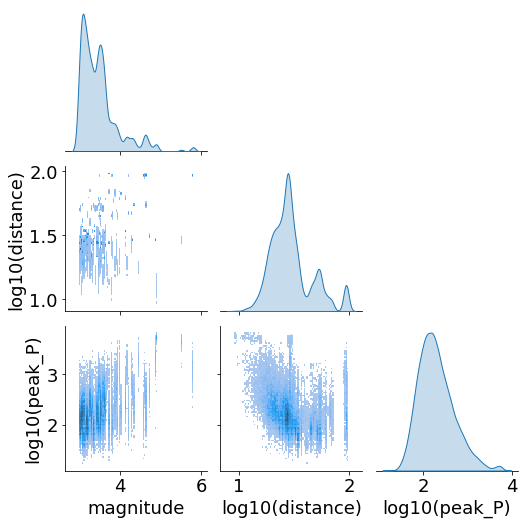

In [8]:
peak_amplitude_df_temp = peak_amplitude_df.iloc[::5, :]
peak_amplitude_df_temp['log10(distance)'] = np.log10(peak_amplitude_df_temp.distance_in_km)
peak_amplitude_df_temp['log10(peak_P)'] = np.log10(peak_amplitude_df_temp.peak_P)
peak_amplitude_df_temp['P/S'] = peak_amplitude_df_temp.peak_P/peak_amplitude_df_temp.peak_S
plt.figure(figsize=(14,8))
sns.pairplot(peak_amplitude_df_temp[['magnitude','log10(distance)', 'log10(peak_P)']], kind='hist', diag_kind="kde", corner=True)
plt.savefig(results_output_dir + '/ridgecrest_data_statistics_simplified.png')

In [ ]:
peak_amplitude_df

In [ ]:
# Load the peak amplitude results of Mammoth data
import pandas as pd
import numpy as np

results_output_dir = '/kuafu/yinjx/multi_array_combined_scaling/combined_strain_scaling_MM'

peak_amplitude_file_name = results_output_dir + '/peak_amplitude_region_site_10.csv'
peak_amplitude_df = pd.read_csv(peak_amplitude_file_name)

In [ ]:
peak_amplitude_df

In [ ]:
peak_amplitude_df_temp = peak_amplitude_df.iloc[::5, :]
peak_amplitude_df_temp['log10(distance)'] = np.log10(peak_amplitude_df_temp.distance_in_km)
peak_amplitude_df_temp['log10(peak_P)'] = np.log10(peak_amplitude_df_temp.peak_P)
peak_amplitude_df_temp['P/S'] = peak_amplitude_df_temp.peak_P/peak_amplitude_df_temp.peak_S
plt.figure(figsize=(14,8))
sns.pairplot(peak_amplitude_df_temp[['magnitude','log10(distance)', 'log10(peak_P)','P/S']], kind='hist', diag_kind="kde", corner=True)
plt.savefig(results_output_dir + '/mammoth_data_statistics.png')

In [ ]:
# path of the ML picking 
ml_pick_dir = '/kuafu/yinjx/Ridgecrest/Ridgecrest_strain_rate_scaling/picking_Weiqiang/picks_yinjx_all'

# Check the segmented 50Hz data
das_path = '/kuafu/yinjx/Ridgecrest/Ridgecrest_strain_rate_scaling/ML_picking_data_eye_picked'

das_dt = 0.02 # downsampled to 50 Hz
for eq_id_current in [38544311]:

    # look for the corresponding ML picks
    ml_picks_file = glob.glob(ml_pick_dir + f'/*{eq_id_current}.csv')
    ml_picks = pd.read_csv(ml_picks_file[0])

    # extract the picked information
    ml_picks_p = ml_picks[ml_picks['phase_type'] == 'p']
    ml_picks_s = ml_picks[ml_picks['phase_type'] == 's']

#     # remove some duplicated picks, only keep those with higher probability
#     ml_picks_p = ml_picks_p.drop_duplicates(subset=['station_name'], keep='first')
#     ml_picks_s = ml_picks_s.drop_duplicates(subset=['station_name'], keep='first')

#     # extrapolate the index in case the ML picking is imcomplete
#     event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p)
#     event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s)

In [ ]:
ml_picks_p

In [ ]:
ml_picks_s

In [ ]:
ml_picks

In [ ]:
ml_picks_p['station_name']

In [ ]:
ml_picks_s[ml_picks_s.duplicated(subset=['station_name'], keep=False)]

In [ ]:
a = np.ones(3)